In [17]:
import time
import pickle
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
import requests
from beir import util
import pathlib
from collections import defaultdict



from data.data_loader import load_data
from models.embedding_model import load_embedding_model
from models.classifier_model import load_classifier_model
from utils.retrieval import encode_corpus, encode_queries, save_embeddings, load_embeddings, retrieve, retrieve_single_query_simple, retrieve_single_query_complex, load_corpus_embeddings_for_evaluation, load_query_embeddings_for_evaluation
from utils.classification import interpret_classification
from utils.evaluation import evaluate_results_multiple_ks, evaluate_results_at_k
from utils.result_eval import eval
from utils.sampling_utils import stratified_sampling, cross_validation_sampling, random_sampling
from utils.llm_utils import generate_answer, evaluate_answers, save_answers_to_json, map_jsons
from utils.classification import interpret_classification, preprocess_question, classify_question

## eval

In [19]:
def create_corpus_embeddings(corpus, model):
    corpus_ids, corpus_embeddings = encode_corpus(corpus, model)
    save_embeddings(corpus_ids, corpus_embeddings, "corpus_embeddings")

def create_query_embeddings(queries, model):
    query_ids, query_embeddings = encode_queries(queries, model)
    save_embeddings(query_ids, query_embeddings, "query_embeddings")

def create_embeddings(corpus, queries, model):
    corpus_ids, corpus_embeddings = encode_corpus(corpus, model)
    query_ids, query_embeddings = encode_queries(queries, model)
    save_embeddings(corpus_ids, corpus_embeddings, "corpus_embeddings")
    save_embeddings(query_ids, query_embeddings, "query_embeddings")

def get_results(corpus, queries, corpus_embeddings, corpus_ids, model, top_k):
    # corpus_ids, corpus_embeddings = load_embeddings("corpus_embeddings")
    query_ids, query_embeddings = load_embeddings("query_embeddings")
    start_time = time.time()
    results = retrieve(corpus_ids, corpus_embeddings, query_ids, query_embeddings, top_k)
    retrieval_time = time.time() - start_time
    print(f"Retrieval Time: {retrieval_time:.2f} seconds")
    print(f"Queries Processed per Second: {len(queries) / retrieval_time:.2f}")
    return results

def save_results(file_path, data):
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)

def load_results(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)

def print_results_with_passages_and_answers(results, queries, corpus, qrels, max_entries=5):
    # Initialize a counter
    count = 0
    
    for query_id, passages in results.items():
        if count >= max_entries:
            break  # Exit the loop if the maximum number of entries has been printed
        
        # Retrieve the question text
        question_text = queries.get(query_id, "Unknown Question")
        
        # Retrieve the gold standard answer
        gold_answer = qrels.get(query_id, "No gold answer found")
        
        print(f"Question: {question_text}")
        print(f"Gold Answer: {gold_answer}")
        print("Retrieved Passages:")
        
        # Retrieve and print the passages
        for doc_id, score in passages:
            passage_text = corpus.get(doc_id, {}).get('text', "No passage found")
            print(f"Passage ID: {doc_id}")
            print(f"Score: {score}")
            print(f"Passage Text: {passage_text}")
            print("-" * 80)  # Separator for readability
        
        print("=" * 80)  # Separator between questions
        
        # Increment the counter
        count += 1

# def generate_save_answers(results, queries, corpus, title, max_retries=5, backoff_factor=1):
#     os.environ["GROQ_API_KEY"] = "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"

#     generated_answers_file = f'./{title}_generated_answers.json'
#     print(f"Generating answers for {len(results)} queries")
#     generated_answers = {}

#     for query_id, passages in tqdm(results.items(), desc="Generating Answers", total=len(results)):
#         passages_text = [corpus[doc_id]['text'] for doc_id, _ in passages]

#         # Retry logic
#         for attempt in range(max_retries):
#             try:
#                 generated_answer = generate_answer(queries[query_id], passages_text)
#                 generated_answers[query_id] = generated_answer
#                 break  # Break out of the retry loop if successful
#             except requests.exceptions.RequestException as e:
#                 wait_time = backoff_factor * (2 ** attempt)
#                 print(f"Error: {e}. Retrying in {wait_time} seconds...")
#                 time.sleep(wait_time)
#         else:
#             print(f"Failed to generate answer for query {query_id} after {max_retries} retries.")
#             generated_answers[query_id] = "Error: Unable to generate answer"

#         # Save the generated answer to the JSON file immediately
#         save_answers_to_json(generated_answers, generated_answers_file, False)

#     print("All answers generated and saved.")

def generate_save_answers(results, queries, corpus, title, processed_queries=set()):
    os.environ["GROQ_API_KEY"] = "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"

    generated_answers_file = f'./{title}_generated_answers.json'
    print(f"Generating answers for {len(results)} queries")
    generated_answers = {}

    for query_id, passages in tqdm(results.items(), desc="Generating Answers", total=len(results)):
        if query_id in processed_queries:
            continue  # Skip already processed queries

        passages_text = [corpus[doc_id]['text'] for doc_id, _ in passages]
        generated_answer = generate_answer(queries[query_id], passages_text)
        generated_answers[query_id] = generated_answer

        # Save the generated answer to the JSON file immediately
        # print(f"saving answers to {generated_answers_file}")
        save_answers_to_json(generated_answers, generated_answers_file, append=True)

        # Update processed queries
        processed_queries.add(query_id)

    return processed_queries

def save_answers_to_json(generated_answers, filename, append=True):
    if append:
        try:
            with open(filename, 'r') as f:
                existing_answers = json.load(f)
        except FileNotFoundError:
            existing_answers = {}
        
        existing_answers.update(generated_answers)

        with open(filename, 'w') as f:
            json.dump(existing_answers, f, indent=4)
    else:
        with open(filename, 'w') as f:
            json.dump(generated_answers, f, indent=4)

def get_results_oe(queries, query_ids, query_embeddings, corpus_ids,
                   corpus_embeddings, corpus, retriever_model, classifier_model, classifier_tokenizer,
                   top_k):

    print("Retrieving for open-ended retrieval method...")
    classifier_model.eval()

    start_time = time.time()

    results = {}
    top_k_values = {}
    for i, (query_id, query_text, query_embedding) in tqdm(enumerate(zip(query_ids, queries.values(), query_embeddings)), desc="Retrieving Documents", total=len(queries)):

        # Classify the query
        classification = interpret_classification(query_text, classifier_model, classifier_tokenizer)
        classification_label = classification['classification']
        confidence_open_ended = classification['confidence_open_ended']
        confidence_not_open_ended = confidence_not_open_ended = classification['confidence_not_open_ended']

        ###### COMPLEXITY SCORE ONLY #####
        # Calculate linguistic complexity
        complexity_score = calculate_linguistic_complexity(query_text)

        # Determine the number of documents to retrieve based on complexity score alone
        if complexity_score < 10:
            top_k = 10  # Less complex, retrieve more documents
        elif complexity_score >= 10 and complexity_score < 20:
            top_k = 7  # Moderately complex, retrieve a moderate number of documents
        else:
            top_k = 5  # Highly complex, retrieve fewer documents


        ###### CLASSIFICATION + COMPLEXITY SCORE #######
        # # Determine the number of documents to retrieve based on classification, confidence, and complexity
        # if classification_label == 'Open-ended':
        #     if confidence_open_ended > 0.8:
        #         top_k = 10 if complexity_score < 10 else 7  # High confidence, more docs if less complex
        #     elif confidence_open_ended > 0.6:
        #         top_k = 7 if complexity_score < 10 else 5   # Medium confidence, moderate docs
        #     else:
        #         top_k = 5 if complexity_score < 10 else 3   # Low confidence, fewer docs
        # else:
        #     if confidence_not_open_ended > 0.8:
        #         top_k = 3 if complexity_score < 10 else 5   # High confidence, fewer docs
        #     elif confidence_not_open_ended > 0.6:
        #         top_k = 5 if complexity_score < 10 else 7   # Medium confidence, moderate docs
        #     else:
        #         top_k = 7 if complexity_score < 10 else 10  # Low confidence, more docs

        # Retrieve relevant passages
        results[query_id] = retrieve_single_query_simple(corpus_ids, corpus_embeddings, query_id, query_embedding, top_k)
        top_k_values[query_id] = top_k  # Store the top_k value used

    end_time = time.time()
    retrieval_time = end_time - start_time

    print(f"Retrieval Time: {retrieval_time:.2f} seconds")
    print(f"Queries Processed per Second: {len(queries) / retrieval_time:.2f}")

    return results, top_k_values, retrieval_time

def evaluate_retrieval_system(type, corpus, queries, corpus_ids, corpus_embeddings, qrels, model, classifier_model, classifier_tokenizer, title, top_k):
    # corpus_ids, corpus_embeddings = load_embeddings("corpus_embeddings")
    # query_ids, query_embeddings = load_embeddings("query_embeddings")

    # start_time = time.time()
    # if type == "base-retrieval-system":
    #     results = get_results(corpus, queries, corpus_ids, corpus_embeddings, model, top_k)
    # elif type == "open-ended-retrieval-system":    
    #     results, top_k_values, _ = get_results_oe(queries, query_ids, query_embeddings, corpus_ids,
    #                                corpus_embeddings, corpus,
    #                                model, classifier_model, classifier_tokenizer, top_k)
    
    # # Save retrieval results
    # print("Saving retrieval results")
    # save_results(f'./{title}_retrieval_results.pkl', results)
    # print("Retrieval results saved")

    # # Save top_k values
    # print("Saving top_k values")
    # save_results(f'./{title}_top_k_values.pkl', top_k_values)
    # print("top_k values saved")

    results = load_results(f'./results/{title}_retrieval_results.pkl')
    print("Retrieval results loaded")

    top_k_values = load_results(f'./results/{title}_top_k_values.pkl')
    print("top-k values loaded")

    # Group queries by top_k and evaluate
    grouped_results = {}
    for query_id, passages in results.items():
        k = top_k_values[query_id]
        if k not in grouped_results:
            grouped_results[k] = {}
        grouped_results[k][query_id] = passages

    # Initialize a metrics dictionary to store results for each top_k
    all_metrics = {}

    # Evaluate each group separately
    for k, group_results in grouped_results.items():
        print(f"Evaluating for top-{k}...")
        evaluate_results_at_k(group_results, queries, corpus, k, qrels)
        
        # Generate answers and compare them to the gold truth for this group
        title_group = f"{title}_top{k}"
        generate_save_answers(group_results, queries, corpus, title_group)
        map_jsons(f'./{title_group}_generated_answers.json', "/content/drive/My Drive/Imperial/Dissertation/datasets/hotpotqa/queries.jsonl", title_group)
        eval(f'./{title_group}_updated_answers.json', title_group)

        # Load metrics for this group
        with open(f'./metrics_{title_group}.json', 'r') as metrics_file:
            metrics = json.load(metrics_file)

        # Add the number of queries analyzed for this top_k group
        metrics['num_queries'] = len(group_results)

        # Save metrics for this group
        all_metrics[k] = metrics
    
    # Optionally, save all metrics for later comparison
    with open(f'./metrics_{title}_all.json', 'w') as metrics_file:
        json.dump(all_metrics, metrics_file, indent=4)

    return all_metrics
    
    # # Generate answers using LLM with a progress bar
    # print("\n\nGenerating answers")
    # os.environ["GROQ_API_KEY"] = "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"
    # generate_save_answers(results, queries, corpus, title)
    # print("Answers generated and saved")

    # retrieval_time = time.time() - start_time
    # print(f"Total Time for Retrieval System Evaluation: {retrieval_time:.2f} seconds")

def evaluation_pipeline(type, model, classifier_model, classifier_tokenizer, corpus, queries, qrels, corpus_embeddings, create_corpus_embeddings_flag, create_query_embeddings_flag, title):
    """
    Runs the evaluation pipeline with the specified sampling strategy.

    Parameters:
    - type: Type of retrieval system (e.g., 'base-retrieval-system', 'open-ended-retrieval-system')
    - model: The embedding model
    - corpus: The corpus of documents
    - queries: The set of queries
    - qrels: The ground truth answers
    - corpus_size: Number of documents to consider in the corpus
    - create_corpus_embeddings_flag: Flag to create corpus embeddings
    - create_query_embeddings_flag: Flag to create query embeddings
    - sampling_type: Type of sampling to use ('random', 'stratified')
    - num_bins: Number of bins for stratified sampling
    - sample_size_per_bin: Number of samples to take per bin in stratified sampling
    """
    # qrels = {k: qrels[k] for k in queries.keys() if k in qrels}
    # print("length of queries", len(queries))
    # print("length of qrels", len(qrels))


    ks = [1, 3, 5, 10]

    if create_corpus_embeddings_flag:
        create_corpus_embeddings(corpus, model)
    if create_query_embeddings_flag:
        create_query_embeddings(queries, model)
    
    print("Loading embeddings")
    corpus_ids = np.load("/Users/anjali/Imperial/dissertation/embeddings/corpus_embeddings_ids.npy", allow_pickle=True).tolist()
    # corpus_embeddings = torch.tensor(np.load("/Users/anjali/Imperial/dissertation/embeddings/corpus_embeddings5m.npy"))

    print("Embeddings loaded")
    # corpus_ids, corpus_embeddings = load_corpus_embeddings_for_evaluation() 
    query_ids, query_embeddings = load_query_embeddings_for_evaluation()
    
    if type == "base-retriever":
        results = get_results(corpus, queries, model, top_k=10)
        evaluate_results_multiple_ks(results, queries, corpus, ks, qrels)
    elif type == "open-ended-retriever":
        classifier_model, classifier_tokenizer = load_classifier_model()
        results, _ = get_results_oe(queries, query_ids, query_embeddings, corpus_ids,
                                    corpus_embeddings, corpus, classifier_model, classifier_tokenizer,
                                    model, top_k=10)
        evaluate_results_multiple_ks(results, queries, corpus, ks, qrels)
    elif type == "base-retrieval-system":
        all_metrics = evaluate_retrieval_system(type, corpus, queries, corpus_ids, corpus_embeddings, qrels, model, classifier_model, classifier_tokenizer, title, top_k=10)
    elif type == "open-ended-retrieval-system":
        all_metrics = evaluate_retrieval_system(type, corpus, queries, corpus_ids, corpus_embeddings, qrels, model, classifier_model, classifier_tokenizer, title, top_k=10)

In [65]:
print("Running mini Benchmark")

data_path = "/Users/anjali/Imperial/dissertation/datasets/hotpotqa/"

# print("Loading data")

train_corpus, train_queries, train_qrels = load_data(data_path, split="train")
test_corpus, test_queries, test_qrels = load_data(data_path, split="test")
dev_corpus, dev_queries, dev_qrels = load_data(data_path, split="dev")

Running mini Benchmark


  0%|          | 0/5233329 [00:00<?, ?it/s]

  0%|          | 0/5233329 [00:00<?, ?it/s]

  0%|          | 0/5233329 [00:00<?, ?it/s]

In [66]:
# Show examples of each variable
full_queries = {**train_queries, **dev_queries, **test_queries}
full_qrels = {**train_qrels, **dev_qrels, **test_qrels}
model = load_embedding_model()
classifier_model, classifier_tokenizer = load_classifier_model()

In [6]:
type = "open-ended-retrieval-system"
corpus_embeddings = [1,2,3]
strat_title = "OEstrat4000_nocomplexretrieval_complexity"
with open("/Users/anjali/Imperial/dissertation/results/OEstrat4000_nocomplexretrieval_complexity_sample.json", "r") as file:
    stratified_sample = json.load(file)

stratified_sample = dict(stratified_sample)
# results = load_results(f'./{title}_retrieval_results.pkl')
# print("Retrieval results loaded")



In [7]:
evaluation_pipeline("open-ended-retrieval-system", model, classifier_model, classifier_tokenizer, train_corpus, stratified_sample, full_qrels, corpus_embeddings, False, False, strat_title)


Loading embeddings
Embeddings loaded
Loading embeddings...
Embeddings loaded.
Retrieval results loaded
top-k values loaded
Evaluating for top-3...
Average Precision@3: 0.34463840399002493
Average Recall@3: 0.5169576059850374
Average NDCG@3: 0.56015183894316
Generating answers for 4010 queries


Generating Answers:   2%|▏         | 94/4010 [03:37<2:30:53,  2.31s/it]
Exception ignored in: <function tqdm.__del__ at 0x7ff6afedd630>
Traceback (most recent call last):
  File "/Users/anjali/opt/anaconda3/envs/imperialenv/lib/python3.10/site-packages/tqdm/std.py", line 1148, in __del__
    def __del__(self):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [12]:
#### process queries and append if groq breaks

results = load_results(f'./results/{strat_title}_retrieval_results.pkl')
top_k_values = load_results(f'./results/{strat_title}_top_k_values.pkl')
title = strat_title

queries = stratified_sample

grouped_results = {}
for query_id, passages in results.items():
    k = top_k_values[query_id]
    if k not in grouped_results:
        grouped_results[k] = {}
    grouped_results[k][query_id] = passages

# Initialize a metrics dictionary to store results for each top_k
all_metrics = {}
k_values_to_evaluate = [10]

# Load processed queries if they exist
processed_queries_file = f'./{title}_top5_generated_answers.json'
try:
    with open(processed_queries_file, 'r') as f:
        processed_queries = set(json.load(f))
except FileNotFoundError:
    processed_queries = set()

# Evaluate each group separately
for k in k_values_to_evaluate:
    if k in grouped_results:
        print(f"Evaluating for top-{k}...")
        group_results = grouped_results[k]
        evaluate_results_at_k(group_results, queries, train_corpus, k, full_qrels)

        # Generate answers and compare them to the gold truth for this group
        title_group = f"{title}_top{k}"
        processed_queries = generate_save_answers(group_results, queries, train_corpus, title_group, processed_queries)

        # Save processed queries
        with open(processed_queries_file, 'w') as f:
            json.dump(list(processed_queries), f)

        map_jsons(f'./{title_group}_generated_answers.json', "/Users/anjali/Imperial/dissertation/datasets/hotpotqa/queries.jsonl", title_group)
        eval(f'./{title_group}_updated_answers.json', title_group)

        # Load metrics for this group
        with open(f'./results/metrics_{title_group}.json', 'r') as metrics_file:
            metrics = json.load(metrics_file)
            all_metrics[k] = metrics
    else:
        print(f"No results for top-{k}")

# Optionally, save all metrics for later comparison
with open(f'./metrics_{title}_all.json', 'w') as metrics_file:
    json.dump(all_metrics, metrics_file, indent=4)

Evaluating for top-10...
Average Precision@10: 0.09411764705882353
Average Recall@10: 0.47058823529411764
Average NDCG@10: 0.4337257473282946
Generating answers for 136 queries


Generating Answers: 100%|██████████| 136/136 [05:34<00:00,  2.46s/it]


{'em': 0.38235294117647056, 'f1': 0.4325032387610052, 'prec': 0.4374478093622571, 'recall': 0.4825144830659538}


FileNotFoundError: [Errno 2] No such file or directory: './results/metrics_OEstrat4000_nocomplexretrieval_complexity_top10.json'

In [10]:
map_jsons('/Users/anjali/Imperial/dissertation/OEstrat4000_nocomplexretrieval_complexity_top7_generated_answers.json', "/Users/anjali/Imperial/dissertation/datasets/hotpotqa/queries.jsonl", strat_title)
# title_group = f"{strat_title}_top5"
# eval(f'./{title_group}_updated_answers.json', title_group)


{'em': 0.25, 'f1': 0.5, 'prec': 0.625, 'recall': 0.4583333333333333}


## Sampling and plots

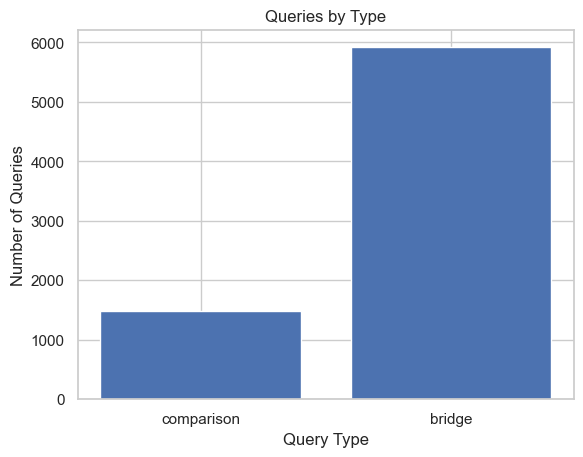

In [62]:
from collections import Counter

# Load JSON data
with open('/Users/anjali/Imperial/dissertation/hotpot_dev_fullwiki_v1.json', 'r') as file:
    data = json.load(file)

# Extract query types
query_types = [entry['type'] for entry in data]

# Count the frequency of each query type
query_type_counts = Counter(query_types)

# Plot the histogram
plt.bar(query_type_counts.keys(), query_type_counts.values())
plt.xlabel('Query Type')
plt.ylabel('Number of Queries')
plt.title('Queries by Type')
plt.savefig('./plots/query_types_histogram.png')
plt.show()

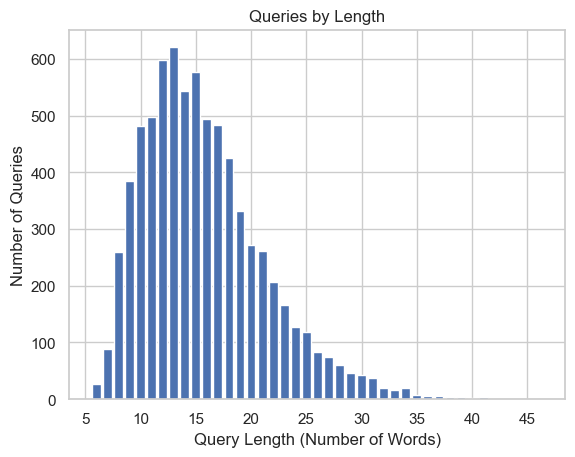

In [60]:
# Extract query length (number of words in the question)
query_lengths = [len(entry['question'].split()) for entry in data]

# Count the frequency of each query length
query_length_counts = Counter(query_lengths)

# Plot the histogram
plt.bar(query_length_counts.keys(), query_length_counts.values())
plt.xlabel('Query Length (Number of Words)')
plt.ylabel('Number of Queries')
plt.title('Queries by Length')
plt.savefig('./plots/query_length_histogram.png')
plt.show()



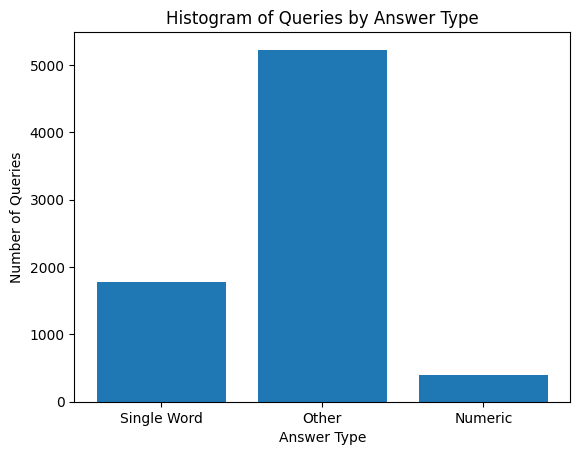

In [9]:
import re

# Function to determine the type of the answer
def determine_answer_type(answer):
    if re.match(r'^\d+$', answer):  # Numeric
        return 'Numeric'
    elif re.match(r'^\w+$', answer):  # Single word (Person, Location, etc.)
        return 'Single Word'
    else:
        return 'Other'

# Extract and classify answer types
answer_types = [determine_answer_type(entry['answer']) for entry in data]

# Count the frequency of each answer type
answer_type_counts = Counter(answer_types)

# Plot the histogram
plt.bar(answer_type_counts.keys(), answer_type_counts.values())
plt.xlabel('Answer Type')
plt.ylabel('Number of Queries')
plt.title('Histogram of Queries by Answer Type')
plt.show()

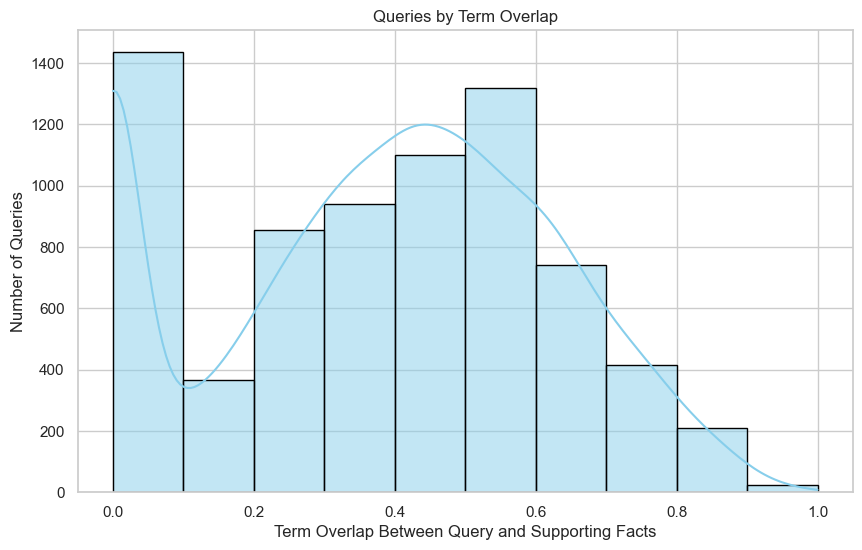

In [57]:
import seaborn as sns

def calculate_term_overlap(query, facts):
    query_terms = set(query.split())
    fact_terms = set(" ".join(facts).split())
    return len(query_terms & fact_terms) / len(query_terms) if query_terms else 0

# Load JSON data
with open('/Users/anjali/Imperial/dissertation/hotpot_dev_fullwiki_v1.json', 'r') as file:
    data = json.load(file)

# Calculate overlap for each query
overlaps = []
for entry in data:
    # Extract the query
    query = entry['question']
    
    # Construct the list of facts using correct indexing
    facts = []
    for i in range(len(entry['supporting_facts'])):
        # Extract title and sentence ID for the current supporting fact
        title = entry['supporting_facts'][i][0]  # Get the title
        sent_index = entry['supporting_facts'][i][1]  # Get the sentence index

        # Search for the title in the context and get the corresponding sentences
        for context_title, sentences in entry['context']:
            if context_title == title:
                if sent_index < len(sentences):
                    facts.append(sentences[sent_index])
                break  # Stop searching once we find the matching title

    # Calculate the overlap and store the result
    overlap = calculate_term_overlap(query, facts)
    overlaps.append(overlap)

# Use Seaborn to plot the histogram
sns.set(style='whitegrid')  # Set the style to white grid for better aesthetics
plt.figure(figsize=(10, 6))
sns.histplot(overlaps, bins=10, kde=True, color='skyblue', edgecolor='black')

plt.xlabel('Term Overlap Between Query and Supporting Facts')
plt.ylabel('Number of Queries')
plt.title('Queries by Term Overlap')

# Save the plot
plt.savefig('./plots/termoverlap_hist.png')
plt.show()

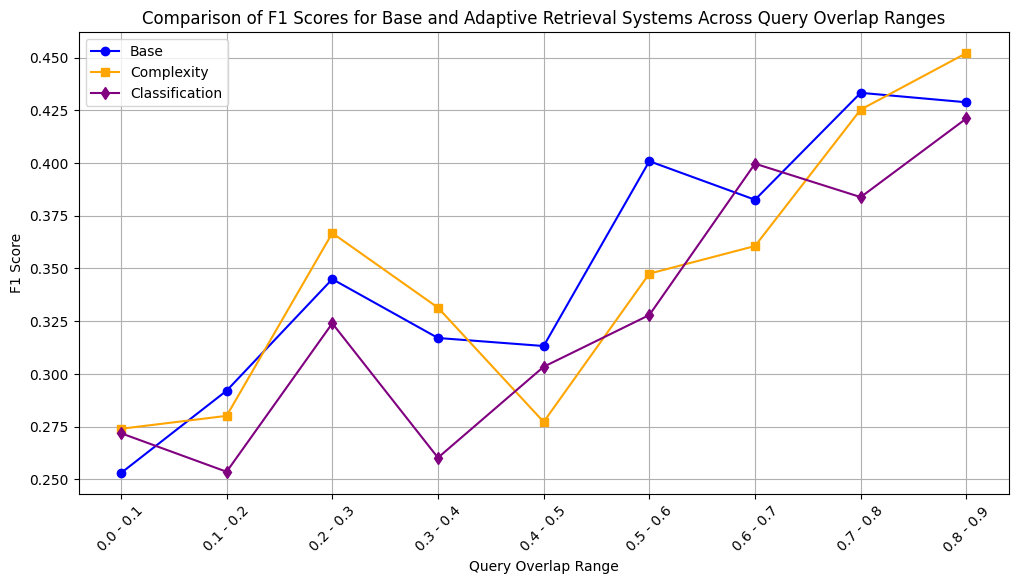

In [55]:
def load_metrics(file_path):
    """
    Load metrics from a JSON file.
    
    Args:
    - file_path (str): Path to the JSON file.

    Returns:
    - dict: A dictionary containing metrics (e.g., em, f1, precision, recall).
    """
    with open(file_path, 'r') as file:
        metrics = json.load(file)
    return metrics

# Initialize lists to store F1 scores for each system
base_f1_scores = []
adaptive_f1_scores_7 = []
adaptive_f1_scores_10 = []
adaptive_complexity_f1_avgs = []  # Weighted average F1 scores for adaptive retrieval (Top 7 & Top 10)
adaptive_classification_f1_weighted_avg = []  # Weighted average F1 scores for the new adaptive system

# Define the query overlap bins as x-axis labels (Bin 1 to Bin 9)
query_overlap_values = [f"{i/10:.1f} - {(i+1)/10:.1f}" for i in range(0, 9)]

# Load metrics and calculate weighted average for each bin
for i in range(1, 10):  # Bins from 1 to 9
    # Load base retrieval metrics
    base_file_path = f'./query_overlap_results/metrics_base_bin{i}.json'
    base_metrics = load_metrics(base_file_path)
    base_f1_scores.append(base_metrics['f1'])

    # Load adaptive retrieval metrics for each bin
    adaptive_file_path = f'./query_overlap_results/metrics_OE_complexity_bin{i}_all.json'
    adaptive_metrics = load_metrics(adaptive_file_path)

    # Extract F1 scores and the number of queries for top 7 and top 10 document retrieval
    f1_score_7 = adaptive_metrics['7']['f1']
    f1_score_10 = adaptive_metrics['10']['f1']
    num_queries_7 = adaptive_metrics['7']['num_queries']
    num_queries_10 = adaptive_metrics['10']['num_queries']
    adaptive_f1_scores_7.append(f1_score_7)
    adaptive_f1_scores_10.append(f1_score_10)
    
    # Calculate the weighted average F1 score for the adaptive retrieval (top-7 and top-10)
    total_queries = num_queries_7 + num_queries_10
    weighted_avg_f1_complexity = (f1_score_7 * num_queries_7 + f1_score_10 * num_queries_10) / total_queries
    adaptive_complexity_f1_avgs.append(weighted_avg_f1_complexity)

    # Load the new adaptive classification metrics
    classification_file_path = f'./query_overlap_results/metrics_OE_classification_bin{i}_all.json'
    classification_metrics = load_metrics(classification_file_path)

    # Calculate the weighted average F1 score for the new adaptive system
    weighted_f1_sum = 0
    total_queries_classification = 0

    for k, metrics in classification_metrics.items():
        num_queries = metrics['num_queries']
        f1_score = metrics['f1']
        weighted_f1_sum += f1_score * num_queries
        total_queries_classification += num_queries

    # Calculate weighted average
    weighted_avg_f1_classification = weighted_f1_sum / total_queries_classification
    adaptive_classification_f1_weighted_avg.append(weighted_avg_f1_classification)

# Plotting F1 scores for comparison
plt.figure(figsize=(12, 6))

# Plot base retrieval F1 scores
plt.plot(query_overlap_values, base_f1_scores, marker='o', linestyle='-', color='b', label='Base')

# Plot adaptive retrieval F1 scores
# plt.plot(query_overlap_values, adaptive_f1_scores_7, marker='x', linestyle='--', color='r', label='Adaptive F1 Score (Top 7)')
# plt.plot(query_overlap_values, adaptive_f1_scores_10, marker='x', linestyle='--', color='g', label='Adaptive F1 Score (Top 10)')

# Plot the weighted average F1 scores for adaptive retrieval (Top 7 & Top 10)
plt.plot(query_overlap_values, adaptive_complexity_f1_avgs, marker='s', linestyle='-', color='orange', label='Complexity')

# # Plot the weighted average F1 scores for the new adaptive system
plt.plot(query_overlap_values, adaptive_classification_f1_weighted_avg, marker='d', linestyle='-', color='purple', label='Classification')

plt.xlabel('Query Overlap Range')
plt.ylabel('F1 Score')
plt.title('Comparison of F1 Scores for Base and Adaptive Retrieval Systems Across Query Overlap Ranges')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.savefig('./query_overlap_results/comparison_f1_scores.png')

plt.show()

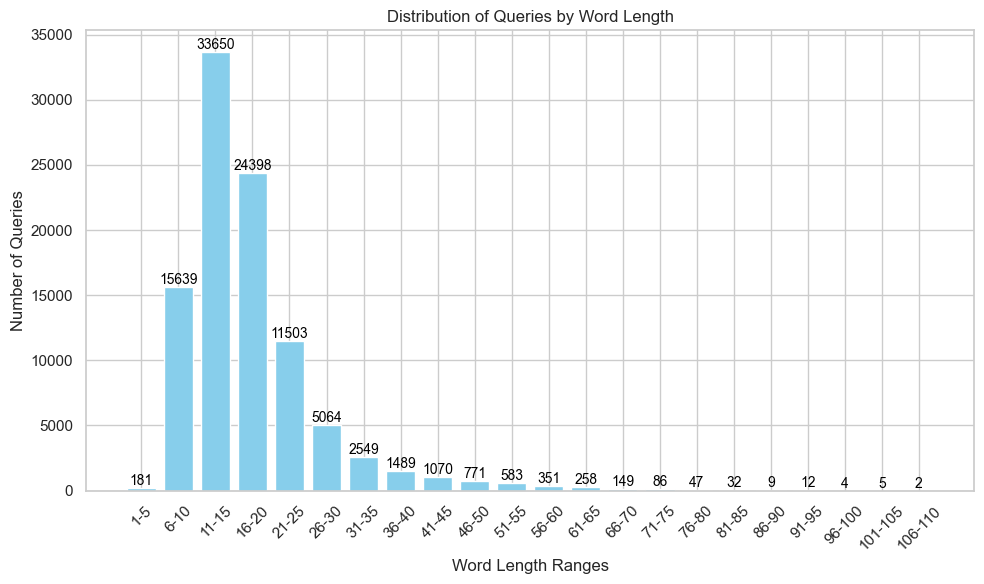

In [72]:
def plot_bins_distribution(queries, bin_size=10):
    # Calculate the length of each query (in words)
    query_lengths = {qid: len(query.split()) for qid, query in queries.items()}
    
    # Group queries by their length ranges
    bins = defaultdict(list)
    for qid, length in query_lengths.items():
        bin_range = (length - 1) // bin_size * bin_size + 1
        bins[bin_range].append(qid)
    
    # Prepare data for plotting
    bin_ranges = []
    query_counts = []
    for bin_range, qids in sorted(bins.items()):
        bin_end = bin_range + bin_size - 1
        bin_label = f"{bin_range}-{bin_end}"
        bin_ranges.append(bin_label)
        query_counts.append(len(qids))
    
    # Plot the histogram
    plt.figure(figsize=(10, 6))
    bars = plt.bar(bin_ranges, query_counts, color='skyblue')
    plt.xlabel('Word Length Ranges')
    plt.ylabel('Number of Queries')
    plt.title('Distribution of Queries by Word Length')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Add the number of queries on top of each bar
    for bar, count in zip(bars, query_counts):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), 
                 ha='center', va='bottom', fontsize=10, color='black')

    # Save and show the plot
    plt.savefig('./plots/query_length_distribution.png')
    plt.show()
# Example usage:
plot_bins_distribution(full_queries, bin_size=5)

In [52]:
def map_jsons(generated_answers_filename, gold_truth_answers_filename, title):
    # Load JSON data (assuming this is in a file named 'generated_answers.json')
    with open(generated_answers_filename, 'r') as file:
        generated_answers = json.load(file)

    # Load JSONL data (assuming this is in a file named 'gold_answers.jsonl')
    id_to_gold_answer = {}
    with open(gold_truth_answers_filename, 'r') as file:
        for line in file:
            item = json.loads(line)
            id_to_gold_answer[item["_id"]] = item["metadata"]["answer"]

    # Update the first JSON object with gold truth answers
    for key in generated_answers:
        if key in id_to_gold_answer:
            generated_answers[key] = {
                "generated_answer": generated_answers[key],
                "gold_truth_answer": id_to_gold_answer[key]
            }

    # Save the updated JSON data (assuming you want to save it to 'updated_answers.json')
    with open(f'./{title}_updated_answers.json', 'w') as file:
        json.dump(generated_answers, file, indent=4)

def save_answers_to_json(generated_answers, filename, update_existing=False):
    if update_existing and os.path.exists(filename):
        with open(filename, 'r') as file:
            existing_data = json.load(file)
        existing_data.update(generated_answers)
        with open(filename, 'w') as file:
            json.dump(existing_data, file, indent=4)
    else:
        with open(filename, 'w') as file:
            json.dump(generated_answers, file, indent=4)